In [218]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/TrueCue/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/TrueCue


# Cluster countries by 14-day new case notification rate over time

In [219]:
!pip install hdbscan

In [220]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan

In [221]:
df=pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
df_pvt=df.pivot(index='date', columns='iso_code', values='new_cases').fillna(0.)

#sorted list of countries with a population over 5M
ctries=df[df.date=='2020-10-16'][df.population>=5000000][['iso_code', 'population']].sort_values('population', ascending=False).iso_code.to_list()[1:]

df_14_day=pd.DataFrame()
for col in df_pvt[ctries].columns:
  df_14_day[col]=df_pvt[col].rolling(window=14).sum()

df_14_day.fillna(0., inplace=True)

for col in df_14_day.columns:
  popn=(df.loc[(df.date=='2020-10-01') & (df.iso_code==col), 'population']/100000).values
  if len(popn) > 0:
    df_14_day[col]=df_14_day[col]/popn
  else:
    print (col)

df_14_day = df_14_day.T.reset_index().rename(columns={'index':'iso_code'})
df_14_day=df_14_day.merge(df[['iso_code','continent','location']], how='left').drop_duplicates().set_index('iso_code')

color_dict={'Asia':1, 'North America':2, 'South America':3, 'Africa':4, 'Europe':5, 'Oceania':6}
df_14_day['color']=df_14_day.continent.apply(lambda x: color_dict[x])
df_14_day['labels']=0

df_14_day.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,...,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-19,2020-09-20,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-26,2020-09-27,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02,2020-10-03,2020-10-04,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-10,2020-10-11,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-17,2020-10-18,2020-10-19,2020-10-20,continent,location,color,labels
iso_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004099,0.002223,0.002223,0.002223,0.00132,0.002501,0.010908,0.012228,0.022719,0.032446,0.039185,0.057180,0.087819,0.134021,0.188700,0.310493,0.412346,0.533237,0.670523,0.814897,0.985393,1.179443,1.393849,1.653137,1.905339,2.106892,2.313725,...,0.021191,0.021468,0.020635,0.021399,0.020843,0.021399,0.021607,0.020982,0.021677,0.021468,0.020635,0.020565,0.020009,0.019870,0.019870,0.019801,0.019315,0.018967,0.019176,0.018828,0.018064,0.018828,0.018620,0.019454,0.021121,0.021955,0.022372,0.022858,0.022580,0.022927,0.023692,0.023483,0.023692,0.024386,0.023831,0.024595,Asia,China,1,0
IND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000072,0.000072,0.000072,0.000145,0.000145,0.000217,0.000217,0.000217,0.000217,0.000217,...,89.787396,90.640002,91.655288,92.603329,93.103690,93.246660,92.968328,92.915719,92.454924,91.786303,91.025508,90.140873,89.722613,89.005152,88.047184,87.347838,86.545450,85.462844,84.458427,83.242779,82.335608,81.334452,80.515759,79.937210,78.809967,77.933883,76.903669,75.784977,74.680125,73.450926,72.065930,70.753398,69.502388,68.490942,67.134424,66.085370,Asia,India,1,0
USA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000302,0.000302,0.000302,0.000302,0.000604,0.000604,0.001511,0.001511,0.001511,0.001511,0.001813,0.002115,0.002417,0.003323,0.003021,0.003021,0.003323,0.003323,0.003021,...,158.248583,160.313219,156.036517,158.247375,157.986954,156.825332,159.634071,168.366025,171.745152,173.558733,175.584699,177.684984,179.058991,179.777112,179.220319,176.665657,181.917578,182.281322,183.568925,186.700018,185.204259,181.443564,182.880109,185.977365,189.780053,190.707236,193.396943,195.617167,198.231949,201.102017,206.359981,212.104346,216.873190,218.671363,222.581302,228.458898,North America,United States,2,0
IDN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,17.083351,17.350969,17.675622,17.680374,17.907777,18.288000,18.487252,18.961068,19.335807,19.759171,20.041779,20.438820,20.686330,20.777365,20.911905,21.092877,21.210234,21.407292,21.563037,21.504176,21.505272,21.302731,21.297247,21.323935,21.402905,21.136383,21.063263,21.291031,21.202556,21.167459,21.110060,21.196707,21.190857,21.298343,21.339656,21.248622,Asia,Indonesia,1,0
PAK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.8407

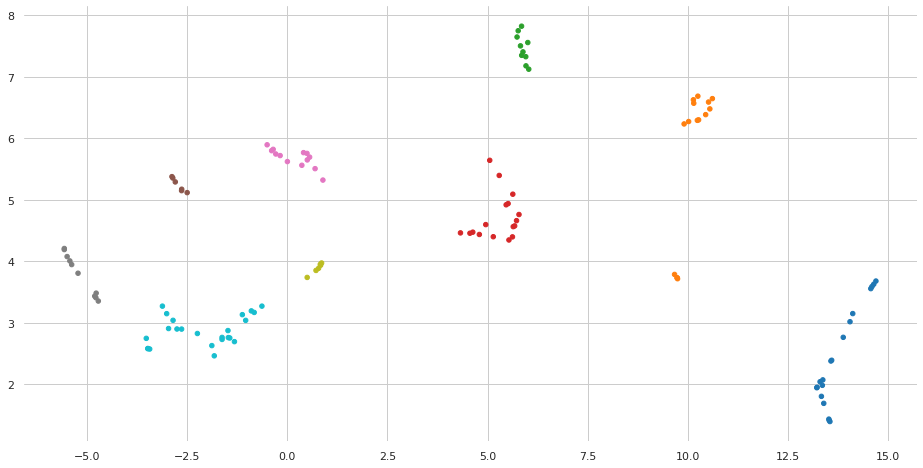

In [222]:
sns.set(style='whitegrid', rc={'figure.figsize':(16,8)})

clusterable_embedding = umap.UMAP(
    n_neighbors=4,
    min_dist=0,
    n_components=2,
    random_state=101,
).fit_transform(df_14_day.iloc[:,:-4])

labels = hdbscan.HDBSCAN(
    min_samples=5,
    min_cluster_size=5,
).fit_predict(clusterable_embedding)

plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            s=20,
            c=labels[clustered],
            cmap='tab10')
plt.box(False);

In [223]:
df_14_day['labels']=labels
df_14_day.labels.value_counts().sort_index()

0    19
1    15
2    10
3    17
4     6
5    13
6    10
7     6
8    24
Name: labels, dtype: int64

In [224]:
for label in sorted(df_14_day.labels.unique()):
  print ('Group '+str(label),df_14_day[df_14_day.labels==label].location.to_list())

Group 0 ['China', 'Vietnam', 'Democratic Republic of Congo', 'Thailand', 'Tanzania', 'Sudan', 'Yemen', 'Niger', 'Taiwan', 'Burkina Faso', 'Mali', 'Cambodia', 'Chad', 'Somalia', 'Burundi', 'South Sudan', 'Papua New Guinea', 'Sierra Leone', 'Laos']
Group 1 ['Nigeria', 'Myanmar', 'South Korea', 'Uganda', 'Angola', 'Malaysia', 'Mozambique', 'Sri Lanka', 'Malawi', 'Syria', 'Rwanda', 'Benin', 'Cuba', 'Togo', 'Liberia']
Group 2 ['Pakistan', 'Egypt', 'Afghanistan', 'Cameroon', "Cote d'Ivoire", 'Senegal', 'Guinea', 'Haiti', 'Tajikistan', 'Nicaragua']
Group 3 ['Indonesia', 'Bangladesh', 'Japan', 'Ethiopia', 'Philippines', 'Kenya', 'Algeria', 'Uzbekistan', 'Ghana', 'Venezuela', 'Madagascar', 'Australia', 'Zambia', 'Zimbabwe', 'Greece', 'Bulgaria', 'Congo']
Group 4 ['Russia', 'Saudi Arabia', 'Sweden', 'United Arab Emirates', 'Belarus', 'Singapore']
Group 5 ['Mexico', 'Iran', 'South Africa', 'Kazakhstan', 'Guatemala', 'Ecuador', 'Bolivia', 'Dominican Republic', 'Azerbaijan', 'Honduras', 'Serbia', '

# Colour by continent - continent not really important in forming the clusters

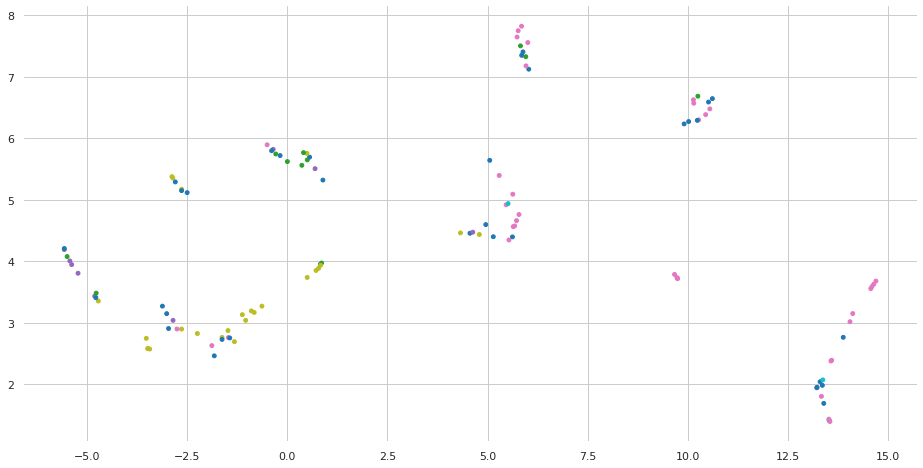

In [225]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            s=15,
            c=df_14_day.color,
            cmap='tab10')
plt.box(False);

# Plot timeline for each cluster. Is there a pattern?

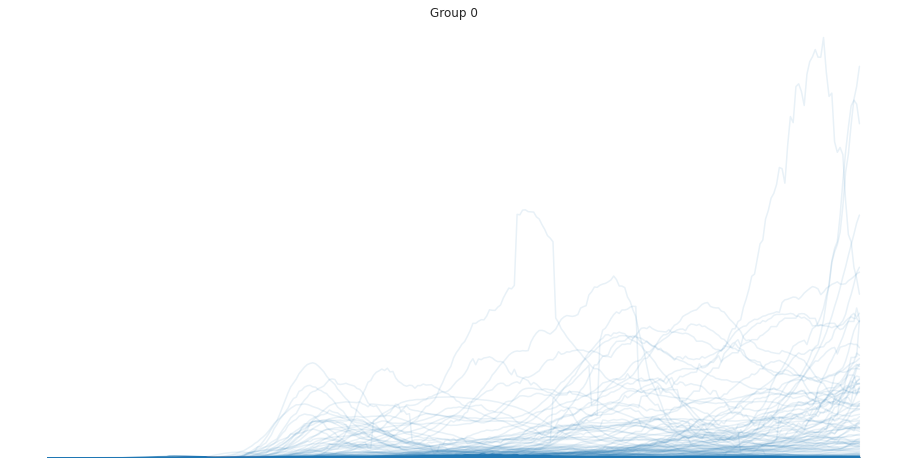

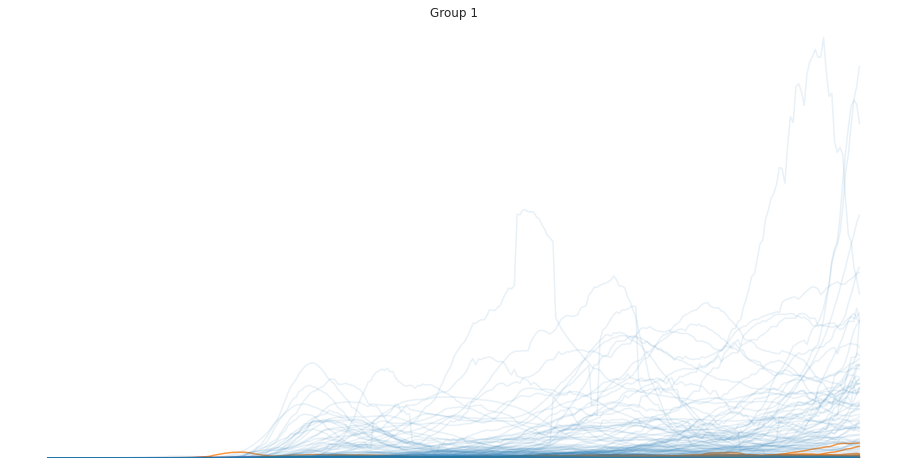

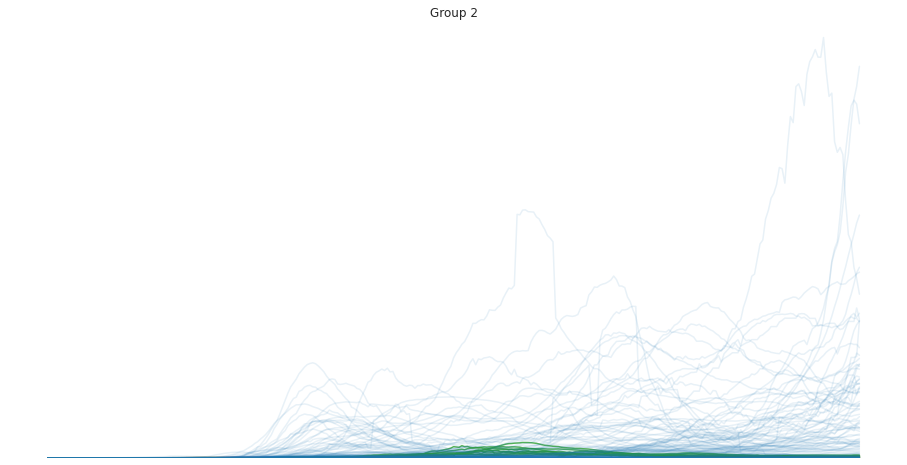

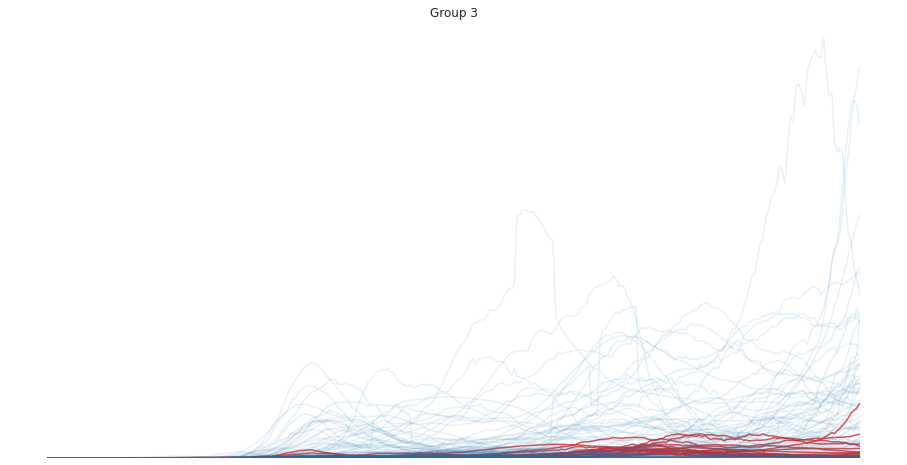

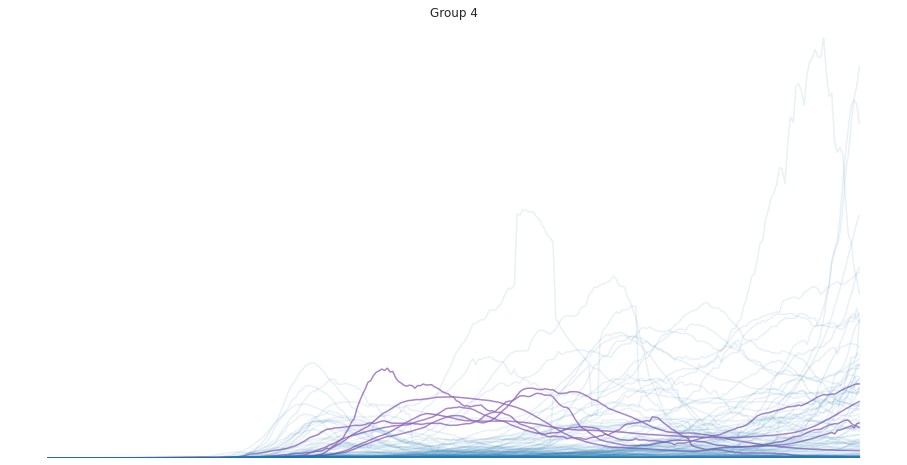

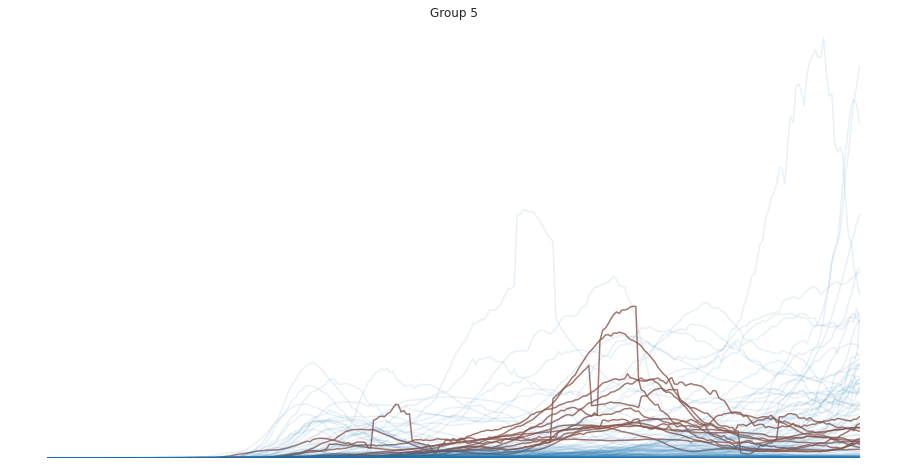

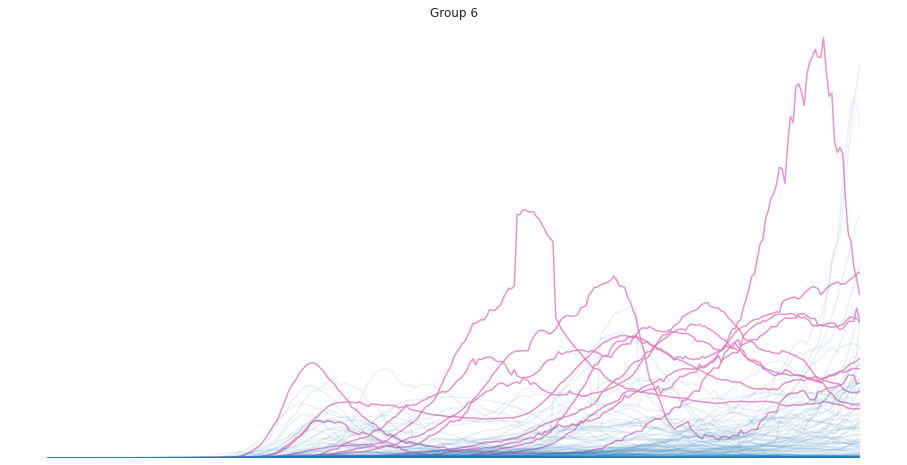

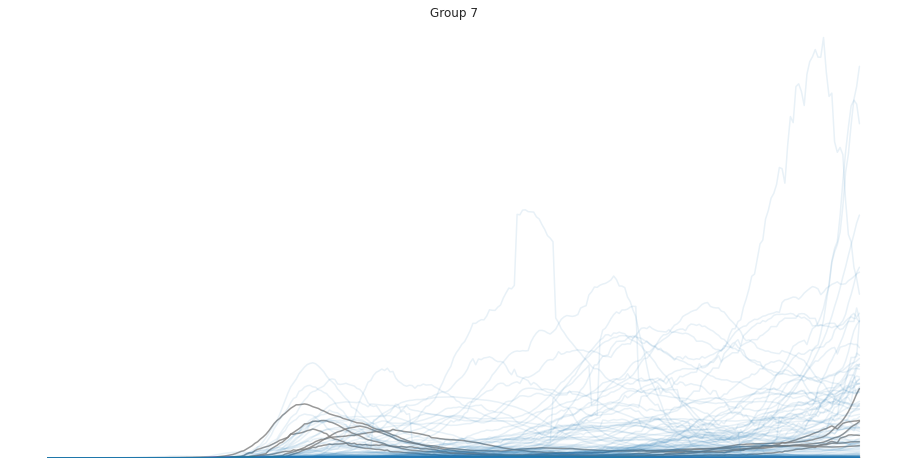

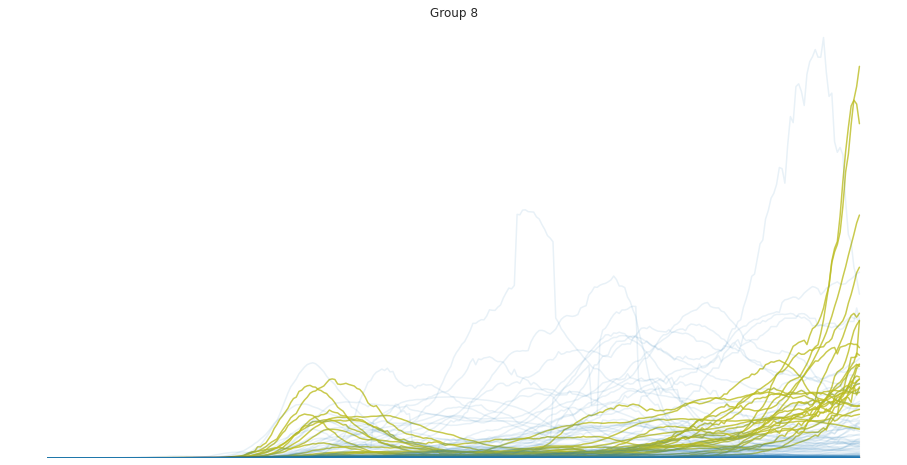

In [226]:
for label in sorted(df_14_day.labels.unique()):

  for ctry in df_14_day[df_14_day.labels==label].index:
    alpha=0.8
    plt.plot(df_14_day.columns[:-4],df_14_day.loc[ctry][:-4], c=cm.tab10(label), alpha=alpha)
    plt.title('Group '+str(label))

  for ctry in df_14_day[df_14_day.labels!=label].index:
    alpha=0.1
    label=0
    plt.plot(df_14_day.columns[:-4],df_14_day.loc[ctry][:-4], c=cm.tab10(label), alpha=alpha)
  
  plt.ylim(0,1000)
  plt.axis('off')
  plt.show();